# Building the Reddit Flair Detector

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cleaning
from nltk import word_tokenize
from nltk.util import ngrams  
from heapq import nlargest
import collections
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
import pickle 

### Reading the extracted data
The extracted data was saved in "reddit-india-data.csv" file. Some submissions had NaN values in the body text maybe because they were simply images or URLs to other sources. These NaN values are replaced by empty strings.

In [2]:
data = pd.read_csv('reddit-india-data.csv', parse_dates=['timestamp'])
data.body.fillna('', inplace=True)
data.tail()

,id,flair,title,body,comments,score,author,url,domain,comms_num,timestamp
2418,fvxp4n,Photography,"Lone House at Loktak Lake, Manipur [OC] [6000x...",,"Location - Loktak Lake, Manipur\n\nDevice us...",18,kingof-potatos,https://i.redd.it/trpvocirv6r41.jpg,reddit.com,3,2020-04-07 01:45:54
2419,fcsymx,Sports,When you cross 30 it affects your eyesight: Ka...,,I can imagine googly-eyed Kohli.,23,Ku_hu,https://www.business-standard.com/article/spor...,business-standard.com,1,2020-03-04 00:31:23
2420,dnrkxp,Sports,Copy India's ambition to be the best: Ian Chap...,,Credit should go to kohli for giving utmost ...,22,Shellynoire,https://www.indiatvnews.com/sports/cricket-cop...,indiatvnews.com,5,2019-10-28 00:00:24
2421,enm17q,Sports,India finish 2019 as number one shooting natio...,,> While **India leads the standings with 30 ...,28,Shellynoire,https://www.thehindu.com/sport/other-sports/in...,thehindu.com,17,2020-01-13 00:06:36
2422,e3umqx,Sports,"Leander Paes betters Davis Cup record, India q...",,Leander's a beast. Respect to this great man...,29,xuxebiko,https://www.thehindu.com/sport/tennis/leander-...,thehindu.com,6,2019-12-01 00:24:26


### Checking the distribution of flairs
From the graph we can note that there are around 250 posts from each of the ten flair. This makes our data **evenly distributed** and hence, appropriate for training machine learning models.

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


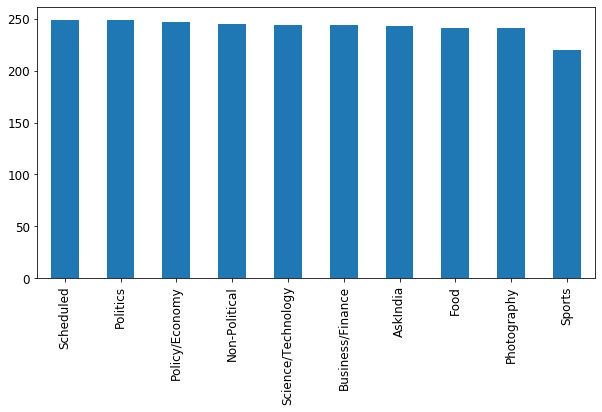

In [3]:
flairs = ['AskIndia', 'Business/Finance', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics', 'Scheduled',
          'Science/Technology', 'Sports']

# Merging megathreads into respective flairs
for flr in flairs:
    data.flair[data.flair == flr +' [Megathread]'] = flr
    
plt.figure(figsize=(10,5))
data.flair.value_counts().plot(kind='bar', fontsize=12);

### Pre-processing the text-data
A separate python script named "cleaning.py" is created which contains all the required function to clean the text. It turns the text into lower case, removes URLs, punctuations, digits, stopwords and lemmatizes the words. Since the r/India submissions have a lot of ***hinglish*** words, a special hinglish stopwords file is used to remove them as well.

In [4]:
cleaning.clean_text(data, 'title')
cleaning.clean_text(data, 'body')
cleaning.clean_text(data, 'comments')

Cleaning text of title ...
DONE! 

Cleaning text of body ...
DONE! 

Cleaning text of comments ...
DONE! 



In [5]:
# Merging title and body text into a new column: content
data['content'] = data.title +' '+ data.body +' '+ data.comments +' '+ data.domain

X = data.content
y = data.flair

# Label encoding the classes (alphabetically by default)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

## ***Feature Extraction and training model***

Displaying topmost related unigrmas and bigrams from each flair's submiisions...

In [6]:
# Finding top ngrams in each flair
top_num = 10

for flair in flairs:
    all_text = ' '.join(str(word) for word in data.content[data.flair == flair].values) 
    tokens = word_tokenize(all_text)
    
    unigrams = ngrams(tokens, 1)
    unigrams = collections.Counter(unigrams).most_common(top_num)
    unigrams = [item[0][0] for item in unigrams]

    bigrams = ngrams(tokens, 2)
    bigrams = collections.Counter(bigrams).most_common(top_num)
    bigrams = [item[0][0]+' '+item[0][1] for item in bigrams]

    print(f"> {flair} \nUnigrams: {unigrams} \nBigrams: {bigrams} \n")

> AskIndia 
Unigrams: ['time', 'make', 'work', 'india', 'life', 'year', 'money', 'parent', 'day', 'indian'] 
Bigrams: ['can not', 'gon na', 'work home', 'social medium', 'pay tax', 'year ago', 'indian parent', 'make money', 'mental health', 'earn money'] 

> Business/Finance 
Unigrams: ['bank', 'money', 'india', 'pay', 'time', 'company', 'make', 'year', 'month', 'work'] 
Bigrams: ['real estate', 'credit card', 'mutual fund', 'uber eats', 'can not', 'gon na', 'bank account', 'stock market', 'net worth', 'make money'] 

> Food 
Unigrams: ['food', 'make', 'eat', 'indian', 'india', 'chicken', 'time', 'add', 'order', 'restaurant'] 
Bigrams: ['indian food', 'burger king', 'peanut butter', 'butter chicken', 'can not', 'fast food', 'condom ad', 'gon na', 'ice cream', 'white rice'] 

> Non-Political 
Unigrams: ['india', 'indian', 'make', 'time', 'work', 'guy', 'day', 'year', 'family', 'country'] 
Bigrams: ['happy birthday', 'gon na', 'can not', 'news channel', 'social medium', 'sorry happen', '

## Part I:  Generating max 5k features with n-grams using TF-IDF Vectorizer

In [7]:
# Splitting data into train:test by 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print("Distribution of classes in test set: \n", np.bincount(y_test))

# Creating the vectorizer
tfidf = TfidfVectorizer(max_features = 5000, ngram_range=(1,3), min_df=5, max_df=0.9, stop_words=cleaning.STOPWORDS )
tfidf = tfidf.fit(X_train)

# Saving the vectorizer as pickle file
with open("vectorizer.pkl", 'wb') as file:  
    pickle.dump(tfidf, file)

X_train = tfidf.transform(X_train).toarray()
print('\nTraining features shape: ',X_train.shape)

X_test = tfidf.transform(X_test).toarray()
print('Test features shape:     ',X_test.shape)

Distribution of classes in test set: 
 [58 44 41 43 47 49 56 50 54 43]

Training features shape:  (1938, 5000)
Test features shape:      (485, 5000)


In [8]:
# Function to train the multi-class classifier

def train_classifier(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    prediction = model.predict(test_data)
    acc = round(accuracy_score(prediction, test_labels)*100, 0)
    print(f'ACCURACY = {acc} %')
    return acc, model

# Creating dictionary to record accuracy of each model
accuracies = {}

### ***1.1 Multinomial Naive Bayes Classifier***
Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [9]:
classifier = naive_bayes.MultinomialNB()
accuracies['Naive Bayes'], nb = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 66.0 %


### ***1.2 Logistic Regression Classifier***
When there are more than two classes to predict, multi_class option is set to 'multinomial'. Solver is the algorithm to use in the optimization problem. Stochastic Average Gradient (sag) is used and it handles L2 regularization by default.

In [10]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
accuracies['Logistic Regression'], logreg = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 68.0 %


### ***1.3 Random Forest Classifier***
The random forest is a model made up of many decision trees to avoid the problem of overfitting. When training, each tree in a random forest learns from a random sample of the data points. The samples are drawn with replacement, known as ***bootstrapping***, which means that some samples will be used multiple times in a single tree. At test time, predictions are made by averaging the predictions of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as ***bagging***. 

n_estimators refers to number of trees, the more the better. min_samples_split refers to the minimum number of samples required to split an internal node.

In [11]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
accuracies['Random Forest'], ranfor = train_classifier(classifier, X_train, y_train, X_test, y_test)
    

ACCURACY = 67.0 %


### ***1.4 Support Vector Machine***
SVM is an efficient classification method when the feature vector is high dimensional. C-Support Vector Classification considers regularisation parameters which help implement a penalty on the misclassifications that are performed while separating the classes; thus helps in improving the accuracy of the output. Smaller values of C lead to large margins.

In [12]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='auto', random_state=42)
accuracies['Linear SVM'], svm = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 68.0 %


In [13]:
# COMPARING ACCURACIES 

models_df = pd.DataFrame(accuracies.items(), columns=['Classifier', 'Accuracy %'])
models_df.sort_values(by=['Accuracy %'], ascending=False).style.hide_index()

Classifier,Accuracy %
Linear SVM,68
Logistic Regression,68
Random Forest,67
Naive Bayes,66


## Part II:  Latent Semantic Analysis
A ***Topic Model*** can be defined as an unsupervised technique to discover topics across various text documents. These topics are abstract in nature, that is, words which are related to each other form a topic. Similarly, there can be multiple topics in an individual document. 

Latent Semantic Analysis (LSA) comes into play as it attempts to capture the hidden concepts in documents, also known as topics. The tf-idf matrix contains 5000 features. To reduce the dimensionality and find latent topics, I will decompose this matrix using Truncated ***SVD***. Here is a function which will return the optimal number of components on the basis of explained variance and the goal variance.

In [14]:
tsvd = TruncatedSVD(n_components = X_train.shape[1]-1, n_iter=10, random_state = 42)
tsvd = tsvd.fit(X_train)
tsvd_var_ratios  = tsvd.explained_variance_ratio_

def select_n_components(var_ratio, goal_var: float) -> int:
    
    # Initialize variance explained and num_components
    total_variance = 0.0
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total and increment components by 1
        total_variance += explained_variance
        n_components += 1
        
        # If goal level of explained variance reached
        if total_variance >= goal_var:
            break 
 
    return n_components

select_n_components(tsvd_var_ratios, 0.9)

1138

In [15]:
tsvd = TruncatedSVD(n_components = 1138, n_iter=10, random_state=42)
tsvd = tsvd.fit(X_train)

# Saving the vectorizer as pickle file
with open("LSA_topics.pkl", 'wb') as file:  
    pickle.dump(tsvd, file)
    
X_train = tsvd.transform(X_train)
X_test = tsvd.transform(X_test)

print('Training features shape: ',X_train.shape)
print('Test features shape:     ',X_test.shape)

Training features shape:  (1938, 1138)
Test features shape:      (485, 1138)


### ***2.1 Multinomial Naive Bayes Classifier***

In [16]:
# Multinomial Naive Bayes Classifier does not support negative values. Input X should be non-negative.
# Hence this classifier is skipped because Truncated SVD transforms X into some negative values as well.

### ***2.2 Logistic Regression Classifier***

In [17]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
accuracies['Logistic Regression'], logreg = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 69.0 %


### ***2.3 Random Forest Classifier***

In [18]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
accuracies['Random Forest'], ranfor = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 68.0 %


### ***2.4 Support Vector Machine***

In [19]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='scale', random_state=42)
accuracies['Linear SVM'], svm = train_classifier(classifier, X_train, y_train, X_test, y_test)


ACCURACY = 70.0 %


In [20]:
# COMPARING ACCURACIES AFTER LSA

models_df = pd.DataFrame(accuracies.items(), columns=['Classifier', 'Accuracy %'])
models_df.drop(models_df[models_df.Classifier == 'Naive Bayes'].index, inplace=True)
models_df.sort_values(by=['Accuracy %'], ascending=False).style.hide_index()

Classifier,Accuracy %
Linear SVM,70
Logistic Regression,69
Random Forest,68


## Best model so far..
*Linear Support Vector Classifier* after performing LSA comes out with an accuracy of **70 %** which is the highest among all. Now evaluating it with various metrics using classification report and confusion matrix.

In [21]:
y_pred = svm.predict(X_test)
print("\nSVM Classifier results: \n")
print(classification_report(y_test, y_pred, target_names = list(encoder.classes_)))


SVM Classifier results: 

                    precision    recall  f1-score   support

          AskIndia       0.67      0.59      0.62        58
  Business/Finance       0.47      0.64      0.54        44
              Food       0.80      0.78      0.79        41
     Non-Political       0.38      0.40      0.39        43
       Photography       0.84      0.89      0.87        47
    Policy/Economy       0.57      0.57      0.57        49
          Politics       0.72      0.70      0.71        56
         Scheduled       1.00      0.96      0.98        50
Science/Technology       0.69      0.65      0.67        54
            Sports       0.95      0.84      0.89        43

          accuracy                           0.70       485
         macro avg       0.71      0.70      0.70       485
      weighted avg       0.71      0.70      0.70       485



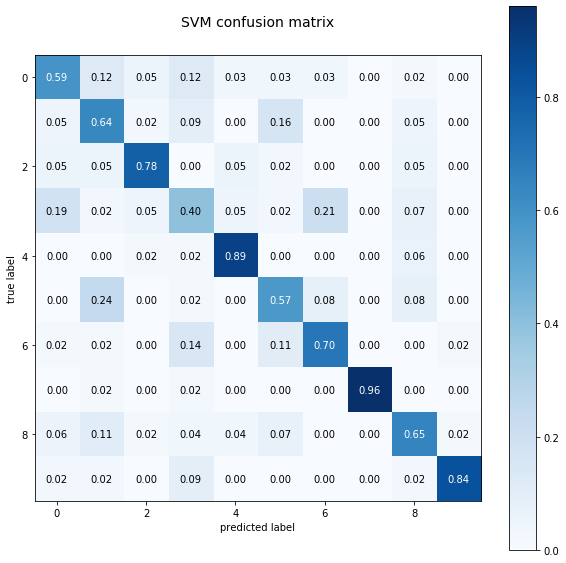

In [22]:
# CREATING THE CONFUSION MATRIX
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                colorbar = True,
                                show_absolute = False,
                                show_normed = True,
                                figsize = (10,10))
plt.title("SVM confusion matrix", fontsize=14)
plt.show()

In [23]:
# Saving the best model as pickle file which would be used in website

with open("pickle_svm_model.pkl", 'wb') as file:  
    pickle.dump(svm, file)